# Size Model

## Loading input

In [1]:
import pickle, os, math, random
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Load the dataset
df = pickle.load(open('dataset/df_2308', 'rb'))

# Sort the data in ascending order based on the 'opdate' column (most recent first)
df.sort_values(by=['opdate'], ascending=True, inplace=True)

# Extract features (x) and target (y) values from the dataFrame
x = df[['age_cal', 'sex', 'weight', 'height', 'cuffed']].astype(float).values
y = df['airway_tube_size'].astype(float).values
c = df['opid'].values

# Separate the data for cuffed and uncuffed endotracheal tubes
## Cuffed endotrahceal tube
x_cuffed = x[x[:, 4] == 1][:, :4]
y_cuffed = y[x[:, 4] == 1]

# Determine the size of the test and train sets for cuffed data
nsamp = len(y_cuffed)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest

# Split the cuffed data into training and test sets
x_cuff_test = x_cuffed[-ntest:, :]
y_cuff_test = y_cuffed[-ntest:]
x_cuff_train = x_cuffed[:ntrain, :]
y_cuff_train = y_cuffed[:ntrain]

# Impute missing values in the cuffed data using the multiple imputation method
imp = IterativeImputer().fit(x_cuff_train)
x_cuff_train = imp.transform(x_cuff_train)
x_cuff_test = imp.transform(x_cuff_test)

## Uncuffed endotracheal tube
x_uncuffed = x[x[:, 4] == 0][:, :4]
y_uncuffed = y[x[:, 4] == 0]

# Determine the size of the test and train sets for uncuffed data
nsamp = len(y_uncuffed)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest

# Split the uncuffed data into training and test sets
x_uncuff_test = x_uncuffed[-ntest:, :]
y_uncuff_test = y_uncuffed[-ntest:]
x_uncuff_train = x_uncuffed[:ntrain, :]
y_uncuff_train = y_uncuffed[:ntrain]

# Impute missing values in the uncuffed data using the multiple imputation method
imp = IterativeImputer().fit(x_uncuff_train)
x_uncuff_train = imp.transform(x_uncuff_train)
x_uncuff_test = imp.transform(x_uncuff_test)

# Print the shapes of the cuffed and uncuffed training and test sets
print(f'x_cuff_train: {(x_cuff_train).shape}, x_cuff_test: {x_cuff_test.shape}')
print(f'x_uncuff_train: {(x_uncuff_train).shape}, x_uncuff_test: {x_uncuff_test.shape}')

x_cuff_train: (10712, 4), x_cuff_test: (2678, 4)
x_uncuff_train: (18934, 4), x_uncuff_test: (4733, 4)


## Feature Selection (BorutaShap)

### Uncuffed model

100%|██████████| 100/100 [04:28<00:00,  2.69s/it]


3 attributes confirmed important: ['age', 'height', 'weight']
1 attributes confirmed unimportant: ['sex']
0 tentative attributes remains: []


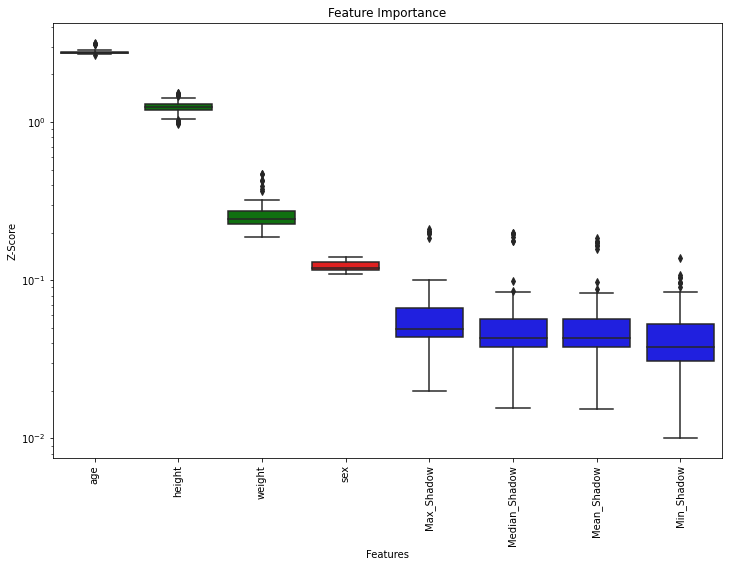

In [5]:
import pandas as pd
import xgboost as xgb
from BorutaShap import BorutaShap

# Define the input variables (features) and target variable (label)
INPUT_VARS = ['age', 'sex', 'weight', 'height']
TARGET_VAR = 'airway_tube_size'

# Create a DataFrame with the training features (X) from the uncuffed data
X = pd.DataFrame(x_uncuff_train, columns=INPUT_VARS)

# Set a random seed for reproducibility
SEED = 98

# Create an XGBoost Regressor model
xgbr = xgb.XGBRegressor()

# Initialize the BorutaShap feature selector
Feature_Selector = BorutaShap(model=xgbr, 
                              importance_measure='shap', 
                              classification=False, 
                              percentile=100, 
                              pvalue=0.05)

# Fit the feature selector to the data
Feature_Selector.fit(X=X, 
                     y=y_uncuff_train, 
                     n_trials=100, 
                     sample=False, 
                     train_or_test='train', 
                     normalize=True, 
                     verbose=True, 
                     random_state=SEED)

# Plot the results of the BorutaShap feature selection
Feature_Selector.plot(X_size=10,
                       which_features='all')

In [2]:
# Exclude the 'sex' feature and concatenate 'age', 'weight', and 'height' features into a new feature set
x_uncuff_train = np.concatenate((x_uncuff_train[:,0:1], x_uncuff_train[:,2:4]),axis=-1)
x_uncuff_test = np.concatenate((x_uncuff_test[:,0:1], x_uncuff_test[:,2:4]),axis=-1)

### Cuffed model

100%|██████████| 100/100 [03:42<00:00,  2.23s/it]


3 attributes confirmed important: ['age', 'height', 'weight']
1 attributes confirmed unimportant: ['sex']
0 tentative attributes remains: []


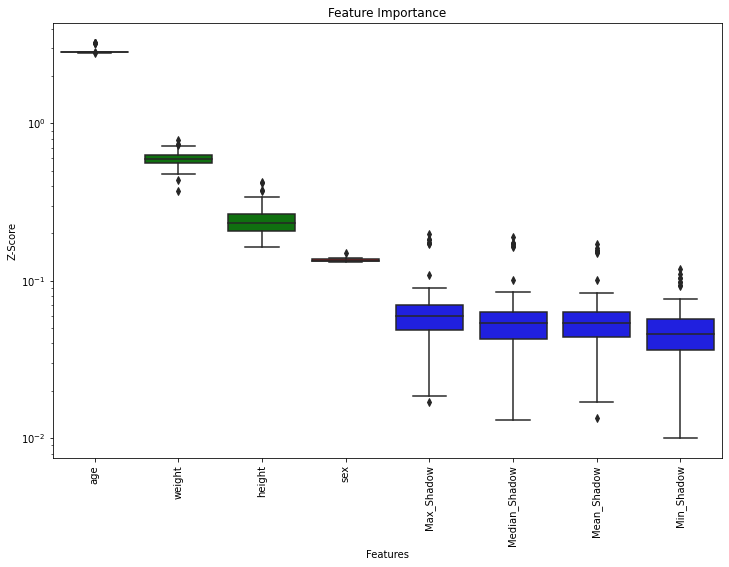

In [4]:
import pandas as pd
import xgboost as xgb
from BorutaShap import BorutaShap

# Define the input variables (features) and target variable (label)
INPUT_VARS = ['age', 'sex', 'weight', 'height']
TARGET_VAR = 'airway_tube_size'

# Create a DataFrame with the training features (X) from the cuffed data
X = pd.DataFrame(x_cuff_train, columns=INPUT_VARS)

# Set a random seed for reproducibility
SEED = 98

# Create an XGBoost Regressor model
xgbr = xgb.XGBRegressor()

# Initialize the BorutaShap feature selector
Feature_Selector = BorutaShap(model=xgbr, 
                              importance_measure='shap', 
                              classification=False, 
                              percentile=100, 
                              pvalue=0.05)

# Fit the feature selector to the data
Feature_Selector.fit(X=X, 
                     y=y_cuff_train, 
                     n_trials=100, 
                     sample=False, 
                     train_or_test='train', 
                     normalize=True, 
                     verbose=True, 
                     random_state=SEED)

# Plot the results of the BorutaShap feature selection
Feature_Selector.plot(X_size=10,
                       which_features='all')

In [3]:
# Exclude the 'sex' feature and concatenate 'age', 'weight', and 'height' features into a new feature set
x_cuff_train = np.concatenate((x_cuff_train[:,0:1], x_cuff_train[:,2:4]),axis=-1)
x_cuff_test = np.concatenate((x_cuff_test[:,0:1], x_cuff_test[:,2:4]),axis=-1)

## Traditional Formula

### Uncuffed model

In [8]:
# Traditional age-based formula (Cole's formula : age / 4 + 4)
y_uncuff_trad1 = np.array([math.floor((math.floor(age) / 4 + 4) * 2) / 2 if age >= 2 else (3.5 if age < 1 else 4) for age in x_uncuff_test[:,0]], dtype=float)

# Get the length of the test data
total = len(x_uncuff_test)

# Lists to store results from bootstrapping
y1_uncuff_trad1s, y2_uncuff_trad1s, f1_uncuff_trad1s = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_uncuff_test[ind]
    boot_y = y_uncuff_test[ind]
    
    # Get the corresponding predictions from the traditional formula for bootstrapped samples
    y_trad = y_uncuff_trad1[ind]
    
    # Round the predicted values to the nearest 0.5 mm
    y_trad = np.round(y_trad * 2) / 2
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_uncuff_trad1s.append(np.mean(y_trad == boot_y))  # Accuracy of predicting exact ETT size
    y2_uncuff_trad1s.append(np.mean((y_trad >= boot_y - 0.5) & (y_trad <= boot_y + 0.5))) # Accuracy within tolerance of 0.5mm 
    yl_test = np.array([f'{i}' for i in boot_y])  # Convert true labels to string for f1_score calculation
    yl_pred = np.array([f'{i}' for i in y_trad])  # Convert predicted labels to string for f1_score calculation
    f1_uncuff_trad1s.append(f1_score(yl_test, yl_pred, average='macro'))  # Calculate and store macro-averaged F1 score for each bootstrapped sample
    
# Print the results of the bootstrapping for the traditional formula for uncuffed ETT
print('* traditional formula for uncuffed ETT (Cole)')
print(f'acc: {np.median(y1_uncuff_trad1s):.3f}, 95% CI {np.percentile(y1_uncuff_trad1s, 5):.3f}-{np.percentile(y1_uncuff_trad1s, 95):.3f}')
print(f'acc within 0.5mm: {np.median(y2_uncuff_trad1s):.3f}, 95% CI {np.percentile(y2_uncuff_trad1s, 5):.3f}-{np.percentile(y2_uncuff_trad1s, 95):.3f}')
print(f'macro f1: {np.median(f1_uncuff_trad1s):.3f}, 95% CI {np.percentile(f1_uncuff_trad1s, 5):.3f}-{np.percentile(f1_uncuff_trad1s, 95):.3f}')

100%|██████████| 10000/10000 [03:02<00:00, 54.91it/s]

* traditional formula for uncuffed ETT (Cole)
acc: 0.203, 95% CI 0.193-0.212
acc within 0.5mm: 0.781, 95% CI 0.771-0.791
macro f1: 0.163, 95% CI 0.140-0.196


In [9]:
# Traditional age-based formula (Penlington's formula : age / 4 + 4.5)
y_uncuff_trad2 = np.array([math.floor((math.floor(age) / 4 + 4.5) * 2) / 2 if age < 6.5 else math.floor((math.floor(age) / 3 + 3.5) * 2) / 2 for age in x_uncuff_test[:,0]], dtype=float)

# Get the length of the test data
total = len(x_uncuff_test)

# Lists to store results from bootstrapping
y1_uncuff_trad2s, y2_uncuff_trad2s, f1_uncuff_trad2s = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_uncuff_test[ind]
    boot_y = y_uncuff_test[ind]
    
    # Get the corresponding predictions from the traditional formula for bootstrapped samples
    y_trad = y_uncuff_trad2[ind]
    
    # Round the predicted values to the nearest 0.5 mm
    y_trad = np.round(y_trad * 2) / 2
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_uncuff_trad2s.append(np.mean(y_trad == boot_y))  # Accuracy of predicting exact ETT size
    y2_uncuff_trad2s.append(np.mean((y_trad >= boot_y - 0.5) & (y_trad <= boot_y + 0.5))) # Accuracy within tolerance of 0.5mm 
    yl_test = np.array([f'{i}' for i in boot_y])  # Convert true labels to string for f1_score calculation
    yl_pred = np.array([f'{i}' for i in y_trad])  # Convert predicted labels to string for f1_score calculation
    f1_uncuff_trad2s.append(f1_score(yl_test, yl_pred, average='macro'))  # Calculate and store macro-averaged F1 score for each bootstrapped sample
    
# Print the results of the bootstrapping for the traditional formula for uncuffed ETT
print('* traditional formula for uncuffed ETT (Penlington)')
print(f'acc: {np.median(y1_uncuff_trad2s):.3f}, 95% CI {np.percentile(y1_uncuff_trad2s, 5):.3f}-{np.percentile(y1_uncuff_trad2s, 95):.3f}')
print(f'acc within 0.5mm: {np.median(y2_uncuff_trad2s):.3f}, 95% CI {np.percentile(y2_uncuff_trad2s, 5):.3f}-{np.percentile(y2_uncuff_trad2s, 95):.3f}')
print(f'macro f1: {np.median(f1_uncuff_trad2s):.3f}, 95% CI {np.percentile(f1_uncuff_trad2s, 5):.3f}-{np.percentile(f1_uncuff_trad2s, 95):.3f}')

100%|██████████| 10000/10000 [03:00<00:00, 55.42it/s]

* traditional formula for uncuffed ETT (Penlington)
acc: 0.413, 95% CI 0.402-0.425
acc within 0.5mm: 0.826, 95% CI 0.817-0.835
macro f1: 0.203, 95% CI 0.196-0.211


### Cuffed model

In [7]:
from tqdm import tqdm
from sklearn.metrics import f1_score

# Traditional age-based formula (Duracher's formula : age / 4 + 3.5)
y_cuff_trad = np.array([math.floor((math.floor(age) / 4 + 3.5) * 2) / 2 if age >= 2 else (3.0 if age < 1 else 3.5) for age in x_cuff_test[:,0]], dtype=float)

# Get the length of the test data
total = len(x_cuff_test)

# Lists to store results from bootstrapping
y1_cuff_trads, y2_cuff_trads, f1_cuff_trads = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_cuff_test[ind]
    boot_y = y_cuff_test[ind]
    
    # Get the corresponding predictions from the traditional formula for bootstrapped samples
    y_trad = y_cuff_trad[ind]
    
    # Round the predicted values to the nearest 0.5 mm
    y_trad = np.round(y_trad * 2) / 2
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_cuff_trads.append(np.mean(y_trad == boot_y))  # Accuracy of predicting exact ETT size
    y2_cuff_trads.append(np.mean((y_trad >= boot_y - 0.5) & (y_trad <= boot_y + 0.5))) # Accuracy within tolerance of 0.5mm 
    yl_test = np.array([f'{i}' for i in boot_y])  # Convert true labels to string for f1_score calculation
    yl_pred = np.array([f'{i}' for i in y_trad])  # Convert predicted labels to string for f1_score calculation
    f1_cuff_trads.append(f1_score(yl_test, yl_pred, average='macro'))  # Calculate and store macro-averaged F1 score for each bootstrapped sample
    
# Print the results of the bootstrapping for the traditional formula for cuffed ETT
print('* traditional formula for cuffed ETT (Duracher)')
print(f'acc: {np.median(y1_cuff_trads):.3f}, 95% CI {np.percentile(y1_cuff_trads, 5):.3f}-{np.percentile(y1_cuff_trads, 95):.3f}')
print(f'acc within 0.5mm: {np.median(y2_cuff_trads):.3f}, 95% CI {np.percentile(y2_cuff_trads, 5):.3f}-{np.percentile(y2_cuff_trads, 95):.3f}')
print(f'macro f1: {np.median(f1_cuff_trads):.3f}, 95% CI {np.percentile(f1_cuff_trads, 5):.3f}-{np.percentile(f1_cuff_trads, 95):.3f}')

100%|██████████| 10000/10000 [01:50<00:00, 90.72it/s]

* traditional formula for cuffed ETT (Duracher)
acc: 0.469, 95% CI 0.453-0.485
acc within 0.5mm: 0.966, 95% CI 0.960-0.972
macro f1: 0.392, 95% CI 0.378-0.406


## Linear regression model

### Uncuffed model

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score

# Create a Linear Regression model for uncuffed endotracheal tube data
lr_uncuff = LinearRegression()

# Fit the model to the training data
lr_uncuff.fit(x_uncuff_train, y_uncuff_train)

# Make predictions on the test data using the trained model
y_pred = lr_uncuff.predict(x_uncuff_test)

# Round the predicted values to the nearest 0.5 mm
y_pred = np.round(y_pred * 2) / 2

# Print the results for the Linear Regression model
print('linear regression model')
print(f'coefficient {lr_uncuff.coef_}, intercept {lr_uncuff.intercept_:.3f}')
print('--------------')

linear regression model
coefficient [ 0.06236239 -0.01501341  0.03575126], intercept 1.549
--------------


In [12]:
# Get the length of the test data
total = len(x_uncuff_test)

# Lists to store results from bootstrapping
y1_uncuff_lrs, y2_uncuff_lrs, f1_uncuff_lrs = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_uncuff_test[ind]
    boot_y = y_uncuff_test[ind]
    
    # Calculate the prediction of linear regression model
    y_lr = lr_uncuff.predict(boot_x)
    
    # Round the predicted values to the nearest 0.5 mm
    y_lr = np.round(y_lr * 2) / 2
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_uncuff_lrs.append(np.mean(y_lr == boot_y))  # Accuracy of predicting exact ETT size
    y2_uncuff_lrs.append(np.mean((y_lr >= boot_y - 0.5) & (y_lr <= boot_y + 0.5))) # Accuracy within tolerance of 0.5mm 
    yl_test = np.array([f'{i}' for i in boot_y])  # Convert true labels to string for f1_score calculation
    yl_pred = np.array([f'{i}' for i in y_lr])  # Convert predicted labels to string for f1_score calculation
    f1_uncuff_lrs.append(f1_score(yl_test, yl_pred, average='macro'))  # Calculate and store macro-averaged F1 score for each bootstrapped sample
    
# Print the results of the bootstrapping for the linear regression model for cuffed ETT
print('* linear regression model for uncuffed ETT')
print(f'acc: {np.median(y1_uncuff_lrs):.3f}, 95% CI {np.percentile(y1_uncuff_lrs, 5):.3f}-{np.percentile(y1_uncuff_lrs, 95):.3f}')
print(f'acc within 0.5mm: {np.median(y2_uncuff_lrs):.3f}, 95% CI {np.percentile(y2_uncuff_lrs, 5):.3f}-{np.percentile(y2_uncuff_lrs, 95):.3f}')
print(f'macro f1: {np.median(f1_uncuff_lrs):.3f}, 95% CI {np.percentile(f1_uncuff_lrs, 5):.3f}-{np.percentile(f1_uncuff_lrs, 95):.3f}')

100%|██████████| 10000/10000 [03:04<00:00, 54.09it/s]

* linear regression model for uncuffed ETT
acc: 0.538, 95% CI 0.525-0.550
acc within 0.5mm: 0.972, 95% CI 0.968-0.976
macro f1: 0.407, 95% CI 0.395-0.424


### Cuffed model

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, f1_score

# Create a Linear Regression model for cuffed endotracheal tube data
lr_cuff = LinearRegression()

# Fit the model to the training data
lr_cuff.fit(x_cuff_train, y_cuff_train)

# Make predictions on the test data using the trained model
y_pred = lr_cuff.predict(x_cuff_test)

# Round the predicted values to the nearest 0.5 mm
y_pred = np.round(y_pred * 2) / 2

# Print the results for the Linear Regression model
print('linear regression model')
print(f'coefficient {lr_cuff.coef_}, intercept {lr_cuff.intercept_:.3f}')
print('--------------')

linear regression model
coefficient [ 0.08874522 -0.00021698  0.02112683], intercept 2.184
--------------


In [11]:
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, f1_score

# Get the length of the test data
total = len(x_cuff_test)

# Lists to store results from bootstrapping
y1_cuff_lrs, y2_cuff_lrs, f1_cuff_lrs = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_cuff_test[ind]
    boot_y = y_cuff_test[ind]
    
    # Calculate the prediction of linear regression model
    y_lr = lr_cuff.predict(boot_x)
    
    # Round the predicted values to the nearest 0.5 mm
    y_lr = np.round(y_lr * 2) / 2
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_cuff_lrs.append(np.mean(y_lr == boot_y))  # Accuracy of predicting exact ETT size
    y2_cuff_lrs.append(np.mean((y_lr >= boot_y - 0.5) & (y_lr <= boot_y + 0.5))) # Accuracy within tolerance of 0.5mm 
    yl_test = np.array([f'{i}' for i in boot_y])  # Convert true labels to string for f1_score calculation
    yl_pred = np.array([f'{i}' for i in y_lr])  # Convert predicted labels to string for f1_score calculation
    f1_cuff_lrs.append(f1_score(yl_test, yl_pred, average='macro'))  # Calculate and store macro-averaged F1 score for each bootstrapped sample
    
# Print the results of the bootstrapping for the linear regression model for cuffed ETT
print('* linear regression model for cuffed ETT')
print(f'acc: {np.median(y1_cuff_lrs):.3f}, 95% CI {np.percentile(y1_cuff_lrs, 5):.3f}-{np.percentile(y1_cuff_lrs, 95):.3f}')
print(f'acc within 0.5mm: {np.median(y2_cuff_lrs):.3f}, 95% CI {np.percentile(y2_cuff_lrs, 5):.3f}-{np.percentile(y2_cuff_lrs, 95):.3f}')
print(f'macro f1: {np.median(f1_cuff_lrs):.3f}, 95% CI {np.percentile(f1_cuff_lrs, 5):.3f}-{np.percentile(f1_cuff_lrs, 95):.3f}')

100%|██████████| 10000/10000 [01:54<00:00, 87.28it/s]

* linear regression model for cuffed ETT
acc: 0.584, 95% CI 0.568-0.599
acc within 0.5mm: 0.994, 95% CI 0.991-0.996
macro f1: 0.576, 95% CI 0.551-0.600


## Gradient-boosted regression tree model

### Uncuffed model

In [6]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# age (일단위)
param_dict = {
                'learning_rate': [ 0.01, 0.03, 0.05, 0.07], #, #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                'gamma': [0.3, 0.5, 0.7, 0.9],
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=1,
                param_grid=param_dict, cv=nfold)
gs.fit(x_uncuff_train, y_uncuff_train)

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

gbrt_uncuff = gs.best_estimator_.get_booster()

y_pred = gbrt_uncuff.predict(xgb.DMatrix(x_uncuff_test)).flatten()
y_pred = np.round(y_pred * 2) / 2

Fitting 10 folds for each of 2880 candidates, totalling 28800 fits

========= found hyperparameter =========
{'colsample_bytree': 0.8, 'gamma': 0.9, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}
0.8940872427069836


In [16]:
# Get the length of the test data
total = len(x_uncuff_test)

# Lists to store results from bootstrapping
y1_uncuff_gbrts, y2_uncuff_gbrts, f1_uncuff_gbrts = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_uncuff_test[ind]
    boot_y = y_uncuff_test[ind]
    
    # Calculate the prediction of gradient-boosted regression tree model
    y_gbrt = gbrt_uncuff.predict((boot_x))
    
    # Round the predicted values to the nearest 0.5 mm
    y_gbrt = np.round(y_gbrt * 2) / 2
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_uncuff_gbrts.append(np.mean(y_gbrt == boot_y))  # Accuracy of predicting exact ETT size
    y2_uncuff_gbrts.append(np.mean((y_gbrt >= boot_y - 0.5) & (y_gbrt <= boot_y + 0.5))) # Accuracy within tolerance of 0.5mm 
    yl_test = np.array([f'{i}' for i in boot_y])  # Convert true labels to string for f1_score calculation
    yl_pred = np.array([f'{i}' for i in y_gbrt])  # Convert predicted labels to string for f1_score calculation
    f1_uncuff_gbrts.append(f1_score(yl_test, yl_pred, average='macro'))  # Calculate and store macro-averaged F1 score for each bootstrapped sample
    
# Print the results of the bootstrapping for the gradient-boosted regression tree model for cuffed ETT
print('* gradient-boosted regression tree model for uncuffed ETT')
print(f'acc: {np.median(y1_uncuff_gbrts):.3f}, 95% CI {np.percentile(y1_uncuff_gbrts, 5):.3f}-{np.percentile(y1_uncuff_gbrts, 95):.3f}')
print(f'acc within 0.5mm: {np.median(y2_uncuff_gbrts):.3f}, 95% CI {np.percentile(y2_uncuff_gbrts, 5):.3f}-{np.percentile(y2_uncuff_gbrts, 95):.3f}')
print(f'macro f1: {np.median(f1_uncuff_gbrts):.3f}, 95% CI {np.percentile(f1_uncuff_gbrts, 5):.3f}-{np.percentile(f1_uncuff_gbrts, 95):.3f}')

100%|██████████| 10000/10000 [06:52<00:00, 24.26it/s]


* gradient-boosted regression tree model for uncuffed ETT
acc: 0.582, 95% CI 0.570-0.594
acc within 0.5mm: 0.981, 95% CI 0.978-0.984
macro f1: 0.502, 95% CI 0.486-0.568


### Cuffed model

In [12]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, r2_score

# age (일단위)
param_dict = {
                'learning_rate': [ 0.01, 0.03, 0.05, 0.07], #, #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                'gamma': [0.3, 0.5, 0.7, 0.9],
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=1,
                param_grid=param_dict, cv=nfold)
gs.fit(x_cuff_train, y_cuff_train)

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

gbrt_cuff = gs.best_estimator_.get_booster()

y_pred = gbrt_cuff.predict(xgb.DMatrix(x_cuff_test)).flatten()
y_pred = np.round(y_pred * 2) / 2

Fitting 10 folds for each of 2880 candidates, totalling 28800 fits

========= found hyperparameter =========
{'colsample_bytree': 1, 'gamma': 0.3, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 300, 'subsample': 1}
0.8740877604545745


In [14]:
# Get the length of the test data
total = len(x_cuff_test)

# Lists to store results from bootstrapping
y1_cuff_gbrts, y2_cuff_gbrts, f1_cuff_gbrts = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_cuff_test[ind]
    boot_y = y_cuff_test[ind]
    
    # Calculate the prediction of gradient-boosted regression tree model
    #y_gbrt = gbrt_cuff.predict(xgb.DMatrix(boot_x))
    y_gbrt = gbrt_cuff.predict((boot_x))
    
    # Round the predicted values to the nearest 0.5 mm
    y_gbrt = np.round(y_gbrt * 2) / 2
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_cuff_gbrts.append(np.mean(y_gbrt == boot_y))  # Accuracy of predicting exact ETT size
    y2_cuff_gbrts.append(np.mean((y_gbrt >= boot_y - 0.5) & (y_gbrt <= boot_y + 0.5))) # Accuracy within tolerance of 0.5mm 
    yl_test = np.array([f'{i}' for i in boot_y])  # Convert true labels to string for f1_score calculation
    yl_pred = np.array([f'{i}' for i in y_gbrt])  # Convert predicted labels to string for f1_score calculation
    f1_cuff_gbrts.append(f1_score(yl_test, yl_pred, average='macro'))  # Calculate and store macro-averaged F1 score for each bootstrapped sample
    
# Print the results of the bootstrapping for the gradient-boosted regression tree model for cuffed ETT
print('* gradient-boosted regression tree model for cuffed ETT')
print(f'acc: {np.median(y1_cuff_gbrts):.3f}, 95% CI {np.percentile(y1_cuff_gbrts, 5):.3f}-{np.percentile(y1_cuff_gbrts, 95):.3f}')
print(f'acc within 0.5mm: {np.median(y2_cuff_gbrts):.3f}, 95% CI {np.percentile(y2_cuff_gbrts, 5):.3f}-{np.percentile(y2_cuff_gbrts, 95):.3f}')
print(f'macro f1: {np.median(f1_cuff_gbrts):.3f}, 95% CI {np.percentile(f1_cuff_gbrts, 5):.3f}-{np.percentile(f1_cuff_gbrts, 95):.3f}')

100%|██████████| 10000/10000 [04:28<00:00, 37.18it/s]


* gradient-boosted regression tree model for cuffed ETT
acc: 0.701, 95% CI 0.686-0.715
acc within 0.5mm: 0.995, 95% CI 0.993-0.997
macro f1: 0.669, 95% CI 0.640-0.694


## Comparison (Cuffed model)

In [5]:
import xgboost as xgb

# Traditional age-based formula (Duracher's formula : age / 4 + 3.5)
y_cuff_trad = np.array([math.floor((math.floor(age) / 4 + 3.5) * 2) / 2 if age >= 2 else (3.0 if age < 1 else 3.5) for age in x_cuff_test[:,0]], dtype=float)

# Linear regression model
lr_cuff = pickle.load(open(f'result/revision1/size/acc1-0.584_acc3-0.994_f1_0.575_LR_cuffed/model','rb'))

# Gradient-boosted regression tree model
gbrt_cuff = xgb.XGBRegressor()
gbrt_cuff.load_model('result/revision1/size/acc1-0.701_acc3-0.995_f10.670_GBRT_cuffed_10fold/model.model')

/home/painstudy/.local/lib/python3.8/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


### Mood's test
* Mood's test for equal scale parameters ([link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html))

### ml-stat-util ([git](https://github.com/mateuszbuda/ml-stat-util))

In [26]:
# Traditional age-based formula (Duracher's formula : age / 4 + 3.5)
y_cuff_trad = np.array([math.floor((math.floor(age) / 4 + 3.5) * 2) / 2 if age >= 2 else (3.0 if age < 1 else 3.5) for age in x_cuff_test[:,0]], dtype=float)
y1_trad = np.mean(y_cuff_trad == y_cuff_test)
y2_trad = np.mean((y_cuff_test - 0.5 <= y_cuff_trad) & (y_cuff_trad <= y_cuff_test + 0.5))
yl_test = np.array([f'{i}' for i in y_cuff_test])
yl_pred = np.array([f'{i}' for i in y_cuff_trad])
f1_trad = f1_score(yl_test, yl_pred, average='macro')


# linear regression
y_cuff_lr = lr_cuff.predict(x_cuff_test)
y_cuff_lr = np.round(y_cuff_lr * 2) / 2
y1_lr = np.mean(y_cuff_lr == y_cuff_test)
y2_lr = np.mean((y_cuff_test - 0.5 <= y_cuff_lr) & (y_cuff_lr <= y_cuff_test + 0.5))
yl_test = np.array([f'{i}' for i in y_cuff_test])
yl_pred = np.array([f'{i}' for i in y_cuff_lr])
f1_lr = f1_score(yl_test, yl_pred, average='macro')


# gbrt
y_cuff_gbrt = gbrt_cuff.predict(x_cuff_test)
y_cuff_gbrt = np.round(y_cuff_gbrt * 2) / 2
y1_gbrt = np.mean(y_cuff_gbrt == y_cuff_test)
y2_gbrt = np.mean((y_cuff_test - 0.5 <= y_cuff_gbrt) & (y_cuff_gbrt <= y_cuff_test + 0.5))
yl_test = np.array([f'{i}' for i in y_cuff_test])
yl_pred = np.array([f'{i}' for i in y_cuff_gbrt])
f1_gbrt = f1_score(yl_test, yl_pred, average='macro')

In [77]:
import stat_util
from sklearn.metrics import f1_score

# define metrics
def acc3(y_true, y_pred, sample_weight=None):
    #y_true = np.array([float(i) for i in y_true])
    #y_pred = np.array([float(i) for i in y_pred])
    return np.mean((y_true - 0.5 <= y_pred) & (y_pred <= y_true + 0.5))

def acc(y_true, y_pred, sample_weight=None):
    return np.mean(y_true == y_pred)

def macrof1(y_true, y_pred, sample_weight=None):
    from sklearn.metrics import f1_score
    return f1_score(y_true, y_pred, average='macro')

# label encoding for calculating macro-averaged f1 score
yl_test = np.array([str(i) for i in y_cuff_test])
yl_gbrt = np.array([str(i) for i in y_cuff_gbrt])
yl_trad = np.array([str(i) for i in y_cuff_trad])
yl_lr = np.array([str(i) for i in y_cuff_lr])

print('comparison of size model for cuffed ETT')
print(f'acc: gbrt vs Duracher - P-value {stat_util.pvalue(y_cuff_test, y_cuff_gbrt, y_cuff_trad, score_fun = acc)[0]:.3f}')  # element 0 is the statistic, 1 is the p-value
print(f'acc: gbrt vs LR model: P-value {stat_util.pvalue(y_cuff_test, y_cuff_gbrt, y_cuff_lr, score_fun = acc)[0]:.3f}')
print(f'acc3: gbrt vs Duracher - P-value {stat_util.pvalue(y_cuff_test, y_cuff_gbrt, y_cuff_trad, score_fun = acc3)[0]:.3f}')  # element 0 is the statistic, 1 is the p-value
print(f'acc3: gbrt vs LR model: P-value {stat_util.pvalue(y_cuff_test, y_cuff_gbrt, y_cuff_lr, score_fun = acc3)[0]:.3f}')
print(f'f1: gbrt vs Duracher - P-value {stat_util.pvalue(yl_test, yl_gbrt, yl_trad, score_fun = macrof1)[0]:.3f}')  # element 0 is the statistic, 1 is the p-value
print(f'f1: gbrt vs LR model: P-value {stat_util.pvalue(yl_test, yl_gbrt, yl_lr, score_fun = macrof1)[0]:.3f}')

comparison of size model for cuffed ETT
acc: gbrt vs Duracher - P-value 0.000
acc: gbrt vs LR model: P-value 0.000
acc3: gbrt vs Duracher - P-value 0.000
acc3: gbrt vs LR model: P-value 0.589
f1: gbrt vs Duracher - P-value 0.000
f1: gbrt vs LR model: P-value 0.000


## Comparison (Uncuffed model)

In [6]:
# Traditional age-based formula (Cole's formula : age / 4 + 4)
y_uncuff_trad1 = np.array([math.floor((math.floor(age) / 4 + 4) * 2) / 2 if age >= 2 else (3.5 if age < 1 else 4.0) for age in x_uncuff_test[:,0]], dtype=float)

# Traditional age-based formula (Penlington's formula : age / 4 + 4.5)
y_uncuff_trad2 = np.array([math.floor((math.floor(age) / 4 + 4.5) * 2) / 2 if age < 6.5 else math.floor((math.floor(age) / 3 + 3.5) * 2) / 2 for age in x_uncuff_test[:,0]], dtype=float)

# Linear regression model
lr_uncuff = pickle.load(open(f'result/revision1/size/acc1-0.538_acc3-0.972_f1_0.409_LR_uncuffed/model','rb'))

# Gradient-boosted regression tree model
gbrt_uncuff = xgb.XGBRegressor()
gbrt_uncuff.load_model('result/revision1/size/acc1-0.582_acc3-0.981_f10.497_GBRT_uncuffed_10fold/model.model')

### ml-stat-util

In [19]:
# Traditional age-based formula (Cole's formula : age / 4 + 4)
y_uncuff_trad1 = np.array([math.floor((math.floor(age) / 4 + 4) * 2) / 2 if age >= 2 else (3.5 if age < 1 else 4) for age in x_uncuff_test[:,0]], dtype=float)

# Traditional age-based formula (Penlington's formula : age / 4 + 4.5)
y_uncuff_trad2 = np.array([math.floor((math.floor(age) / 4 + 4.5) * 2) / 2 if age < 6.5 else math.floor((math.floor(age) / 3 + 3.5) * 2) / 2 for age in x_uncuff_test[:,0]], dtype=float)

# linear regression
y_uncuff_lr = lr_uncuff.predict(x_uncuff_test)
y_uncuff_lr = np.round(y_uncuff_lr * 2) / 2

# gbrt
y_uncuff_gbrt = gbrt_uncuff.predict(x_uncuff_test)
y_uncuff_gbrt = np.round(y_uncuff_gbrt * 2) / 2

In [76]:
import stat_util
from sklearn.metrics import f1_score

# define metrics
def acc3(y_true, y_pred, sample_weight=None):
    #y_true = np.array([float(i) for i in y_true])
    #y_pred = np.array([float(i) for i in y_pred])
    return np.mean((y_true - 0.5 <= y_pred) & (y_pred <= y_true + 0.5))

def acc(y_true, y_pred, sample_weight=None):
    return np.mean(y_true == y_pred)

def macrof1(y_true, y_pred, sample_weight=None):
    from sklearn.metrics import f1_score
    return f1_score(y_true, y_pred, average='macro')

yl_test = np.array([str(i) for i in y_uncuff_test])
yl_gbrt = np.array([str(i) for i in y_uncuff_gbrt])
yl_trad1 = np.array([str(i) for i in y_uncuff_trad1])
yl_trad2 = np.array([str(i) for i in y_uncuff_trad2])
yl_lr = np.array([str(i) for i in y_uncuff_lr])

print('comparison of size model for uncuffed ETT')
print(f'acc: gbrt vs Cole - P-value {stat_util.pvalue(y_uncuff_test, y_uncuff_gbrt, y_uncuff_trad1, score_fun = acc)[0]:.3f}')  # element 0 is the p-value, 1 is the statistic
print(f'acc: gbrt vs Penlington - P-value {stat_util.pvalue(y_uncuff_test, y_uncuff_gbrt, y_uncuff_trad2, score_fun = acc)[0]:.3f}') 
print(f'acc: gbrt vs LR model: P-value {stat_util.pvalue(y_uncuff_test, y_uncuff_gbrt, y_uncuff_lr, score_fun = acc)[0]:.3f}')
print(f'acc3: gbrt vs Cole - P-value {stat_util.pvalue(y_uncuff_test, y_uncuff_gbrt, y_uncuff_trad1, score_fun = acc3)[0]:.3f}') 
print(f'acc3: gbrt vs Penlington - P-value {stat_util.pvalue(y_uncuff_test, y_uncuff_gbrt, y_uncuff_trad2, score_fun = acc3)[0]:.3f}') 
print(f'acc3: gbrt vs LR model: P-value {stat_util.pvalue(y_uncuff_test, y_uncuff_gbrt, y_uncuff_lr, score_fun = acc3)[0]:.3f}')
print(f'f1: gbrt vs Cole - P-value {stat_util.pvalue(yl_test, yl_gbrt, yl_trad1, score_fun = macrof1)[0]:.3f}')  
print(f'f1: gbrt vs Penlington - P-value {stat_util.pvalue(yl_test, yl_gbrt, yl_trad2, score_fun = macrof1)[0]:.3f}')  
print(f'f1: gbrt vs LR model: P-value {stat_util.pvalue(yl_test, yl_gbrt, yl_lr, score_fun = macrof1)[0]:.3f}')

comparison of size model for uncuffed ETT
acc: gbrt vs Cole - P-value 0.000
acc: gbrt vs Penlington - P-value 0.000
acc: gbrt vs LR model: P-value 0.000
acc3: gbrt vs Cole - P-value 0.000
acc3: gbrt vs Penlington - P-value 0.000
acc3: gbrt vs LR model: P-value 0.000
f1: gbrt vs Cole - P-value 0.000
f1: gbrt vs Penlington - P-value 0.000
f1: gbrt vs LR model: P-value 0.000


# SHAP

## Uncuffed model

### summary plot

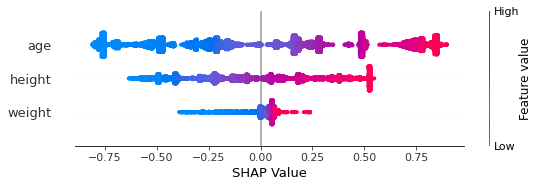

In [13]:
import xgboost as xgb
import shap

# Gradient-boosted regression tree model
gbrt_uncuff = xgb.XGBRegressor()
gbrt_uncuff.load_model('result/revision1/size/acc1-0.582_acc3-0.981_f10.497_GBRT_uncuffed_10fold/model.model')

shap.initjs()
explainer = shap.TreeExplainer(gbrt_uncuff)
shap_values = explainer.shap_values(xgb.DMatrix(x_uncuff_train))


INPUT_VARS = ['age','weight','height']

X_train = pd.DataFrame(x_uncuff_train, columns=INPUT_VARS)

fig = plt.figure(figsize=(12,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(shap_values, X_train, show=False)
ax.set_xlabel('SHAP Value')
#ax.set_title('SHAP Dot Plot', fontsize=20)
plt.savefig("figures/Suppl_Fig1_a_size_SHAP.png", dpi=600)
plt.show()

### dependence plot

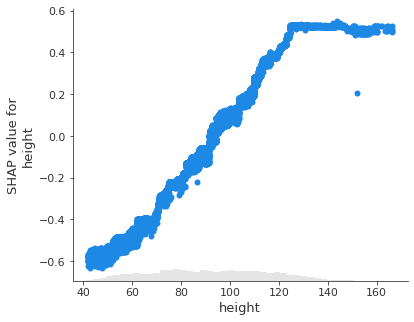

In [24]:
INPUT_VARS = ['age','weight','height']

X_train = pd.DataFrame(x_uncuff_train, columns=INPUT_VARS)

shap_xgb = explainer(X_train)
shap.plots.scatter(shap_xgb[:,'height'], dot_size = None, show=False)
#plt.rcParams['font.family'] = 'AvenirNextLTPro'
plt.savefig("figures/Suppl_Fig2_c_uncuff_height.png", dpi=600, bbox_inches='tight', pad_inches=0.5)

## Cuffed model

### summary plot

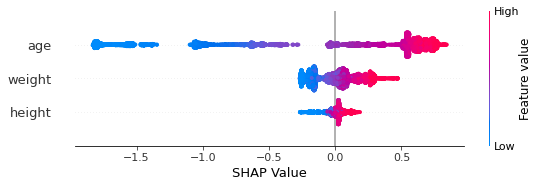

In [14]:
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# Loading Gradient-boosted regression tree model
gbrt_cuff = xgb.XGBRegressor()
gbrt_cuff.load_model('result/revision1/size/acc1-0.701_acc3-0.995_f10.670_GBRT_cuffed_10fold/model.model')

# calculation of shap values
shap.initjs()
explainer = shap.TreeExplainer(gbrt_cuff)
shap_values = explainer.shap_values(xgb.DMatrix(x_cuff_train))


# plot shap summary plot
INPUT_VARS = ['age','weight','height']

X_train = pd.DataFrame(x_cuff_train, columns=INPUT_VARS)

fig = plt.figure(figsize=(12,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(shap_values, X_train, show=False)
ax.set_xlabel('SHAP Value')
#ax.set_title('SHAP Dot Plot', fontsize=20)
plt.savefig("figures/Suppl_Fig1_b_size_SHAP.png", dpi=600)
plt.show()

### dependence plot

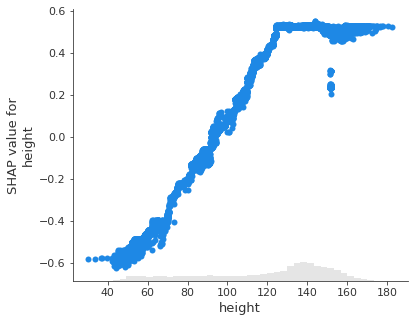

In [27]:
# plot shap summary plot
INPUT_VARS = ['age','weight','height']

X_train = pd.DataFrame(x_cuff_train, columns=INPUT_VARS)

shap_xgb = explainer(X_train)
shap.plots.scatter(shap_xgb[:,'height'], dot_size = None, show=False)
#plt.rcParams['font.family'] = 'AvenirNextLTPro'
plt.savefig("figures/Suppl_Fig2_f_cuff_height.png", dpi=600, bbox_inches='tight', pad_inches=0.5)

In [ ]:
shap.plots.scatter(shap_xgb[:,'cuffed'], x_jitter=0.1, dot_size = None, show=False)
plt.xticks([0,1], ['uncuffed', 'cuffed'])
plt.savefig("figures/Fig5_d_cuffed.png", dpi=600, bbox_inches='tight', pad_inches=0.5)
plt.show()

# Subgroup analysis

## Cuffed model

In [116]:
# Exclude the 'sex' feature and concatenate 'age', 'weight', and 'height' features into a new feature set
x_cuff_train = np.concatenate((x_cuff_train[:,0:1], x_cuff_train[:,2:4]),axis=-1)
x_cuff_test = np.concatenate((x_cuff_test[:,0:1], x_cuff_test[:,2:4]),axis=-1)

In [19]:
import xgboost as xgb

# xgbr model
gbrt_cuff = xgb.XGBRegressor()
gbrt_cuff.load_model('result/revision1/size/acc1-0.701_acc3-0.995_f10.670_GBRT_cuffed_10fold/model.model')

y_xgbr = gbrt_cuff.predict(x_cuff_test)
y_xgbr = np.round(y_xgbr * 2) / 2

In [132]:
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# neonate
sub_mask = x_cuff_test[:,0]<1/12
x1_cuff_test = x_cuff_test[sub_mask]
y1_cuff_test = y_cuff_test[sub_mask]

nruns = 10000
total = len(y1_cuff_test)
y1_gbrts, y2_gbrts, f1_gbrts = [], [], []

for i in tqdm(range(nruns)):
    mask = np.random.randint(total, size=total)

    X1_cuff_test = x1_cuff_test[mask]
    Y_cuff_test = y1_cuff_test[mask]
    
    y_gbrt = gbrt_cuff.predict(X1_cuff_test)
    y_gbrt = np.round(y_gbrt * 2) / 2
    y1_gbrts.append(np.mean(y_gbrt == Y_cuff_test))
    y2_gbrts.append(np.mean((y_gbrt >= Y_cuff_test-0.5) & (y_gbrt <= Y_cuff_test+0.5)))
    
    # F1 score
    yl_test = np.array([f'{i}' for i in Y_cuff_test])
    yl_gbrt = np.array([f'{i}' for i in y_gbrt])
    f1_gbrts.append(f1_score(yl_test, yl_gbrt, average='macro'))

print('###newborns###')
print(f'acc: {np.mean(y1_gbrts):.3f}+-{np.std(y1_gbrts):.3f}, 95% CI {np.percentile(y1_gbrts, 5):.3f}-{np.percentile(y1_gbrts, 95):.3f}')
print(f'acc within 0.5mm: {np.mean(y2_gbrts):.3f}+-{np.std(y2_gbrts):.3f}, 95% CI {np.percentile(y2_gbrts, 5):.3f}-{np.percentile(y2_gbrts, 95):.3f}')
print(f'macro f1: {np.mean(f1_gbrts):.3f}+-{np.std(f1_gbrts):.3f}, 95% CI {np.percentile(f1_gbrts, 5):.3f}-{np.percentile(f1_gbrts, 95):.3f}')



# infant
sub_mask = (x_cuff_test[:,0]<=1)&(x_cuff_test[:,0]>1/12)
x1_cuff_test = x_cuff_test[sub_mask]
y1_cuff_test = y_cuff_test[sub_mask]

total = len(y1_cuff_test)
y1_gbrts, y2_gbrts, f1_gbrts = [], [], []
for i in tqdm(range(nruns)):   
    mask = np.random.randint(total, size=total)
    X1_cuff_test = x1_cuff_test[mask]
    Y_cuff_test = y1_cuff_test[mask]
    
    y_gbrt = gbrt_cuff.predict(X1_cuff_test)
    y_gbrt = np.round(y_gbrt * 2) / 2
    y1_gbrts.append(np.mean(y_gbrt == Y_cuff_test))
    y2_gbrts.append(np.mean((y_gbrt >= Y_cuff_test-0.5) & (y_gbrt <= Y_cuff_test+0.5)))
    
    # F1 score
    yl_test = np.array([f'{i}' for i in Y_cuff_test])
    yl_gbrt = np.array([f'{i}' for i in y_gbrt])
    f1_gbrts.append(f1_score(yl_test, yl_gbrt, average='macro'))
    
print('\n###infants (1/12mo<age<=1yr)###')
print(f'acc: {np.mean(y1_gbrts):.3f}+-{np.std(y1_gbrts):.3f}, 95% CI {np.percentile(y1_gbrts, 5):.3f}-{np.percentile(y1_gbrts, 95):.3f}')
print(f'acc within 0.5mm: {np.mean(y2_gbrts):.3f}+-{np.std(y2_gbrts):.3f}, 95% CI {np.percentile(y2_gbrts, 5):.3f}-{np.percentile(y2_gbrts, 95):.3f}')
print(f'macro f1: {np.mean(f1_gbrts):.3f}+-{np.std(f1_gbrts):.3f}, 95% CI {np.percentile(f1_gbrts, 5):.3f}-{np.percentile(f1_gbrts, 95):.3f}')


# the others
sub_mask = x_cuff_test[:,0]>1
x1_cuff_test = x_cuff_test[sub_mask]
y1_cuff_test = y_cuff_test[sub_mask]

total = len(y1_cuff_test)
y1_gbrts, y2_gbrts, f1_gbrts = [], [], []
for i in tqdm(range(nruns)):
    mask = np.random.randint(total, size=total)
    X1_cuff_test = x1_cuff_test[mask]
    Y_cuff_test = y1_cuff_test[mask]
    
    y_gbrt = gbrt_cuff.predict(X1_cuff_test)
    y_gbrt = np.round(y_gbrt * 2) / 2
    y1_gbrts.append(np.mean(y_gbrt == Y_cuff_test))
    y2_gbrts.append(np.mean((y_gbrt >= Y_cuff_test-0.5) & (y_gbrt <= Y_cuff_test+0.5)))
    
    # F1 score
    yl_test = np.array([f'{i}' for i in Y_cuff_test])
    yl_gbrt = np.array([f'{i}' for i in y_gbrt])
    f1_gbrts.append(f1_score(yl_test, yl_gbrt, average='macro'))
    
print('\n###others(age>1yr)###')
print(f'acc: {np.mean(y1_gbrts):.3f}+-{np.std(y1_gbrts):.3f}, 95% CI {np.percentile(y1_gbrts, 5):.3f}-{np.percentile(y1_gbrts, 95):.3f}')
print(f'acc within 0.5mm: {np.mean(y2_gbrts):.3f}+-{np.std(y2_gbrts):.3f}, 95% CI {np.percentile(y2_gbrts, 5):.3f}-{np.percentile(y2_gbrts, 95):.3f}')
print(f'macro f1: {np.mean(f1_gbrts):.3f}+-{np.std(f1_gbrts):.3f}, 95% CI {np.percentile(f1_gbrts, 5):.3f}-{np.percentile(f1_gbrts, 95):.3f}')


100%|██████████| 10000/10000 [01:06<00:00, 150.34it/s]


###newborns###
acc: 0.883+-0.033, 95% CI 0.830-0.936
acc within 0.5mm: 1.000+-0.000, 95% CI 1.000-1.000
macro f1: 0.541+-0.071, 95% CI 0.459-0.674


100%|██████████| 10000/10000 [02:06<00:00, 78.87it/s]



###infants (1/12mo<age<=1yr)###
acc: 0.824+-0.013, 95% CI 0.802-0.846
acc within 0.5mm: 0.996+-0.002, 95% CI 0.993-0.999
macro f1: 0.510+-0.076, 95% CI 0.429-0.632


100%|██████████| 10000/10000 [03:15<00:00, 51.05it/s]



###others(age>1yr)###
acc: 0.631+-0.012, 95% CI 0.612-0.650
acc within 0.5mm: 0.994+-0.002, 95% CI 0.990-0.997
macro f1: 0.626+-0.020, 95% CI 0.591-0.657


In [20]:
from tqdm import tqdm

# Get the length of the test data
total = len(x_cuff_test)

# Traditional age-based formula (Cole's formula : age / 4 + 4)
y_cuff_trad1 = np.array([math.floor((math.floor(age) / 4 + 4) * 2) / 2 if age >= 2 else (3.5 if age < 1 else 4) for age in x_cuff_test[:,0]], dtype=float)

# Traditional age-based formula (Penlington's formula : age / 4 + 4.5)
y_cuff_trad2 = np.array([math.floor((math.floor(age) / 4 + 4.5) * 2) / 2 if age < 6.5 else math.floor((math.floor(age) / 3 + 3.5) * 2) / 2 for age in x_cuff_test[:,0]], dtype=float)

# Lists to store results from bootstrapping
y1_new, y2_new, f1_new = [], [], []
y1_inf, y2_inf, f1_inf = [], [], []
y1_oth, y2_oth, f1_oth = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_cuff_test[ind]
    boot_y = y_cuff_test[ind]
    
    # newborn
    mask1 = boot_x[:,0] < 1/12
    
    # Calculate the prediction of gradient-boosted regression tree model
    y_new = gbrt_cuff.predict((boot_x[mask1]))
    boot_y1 = boot_y[mask1]
    
    # Round the predicted values to the nearest 0.5 mm
    y_new = np.round(y_new * 2) / 2
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_new.append(np.mean(y_new == boot_y1))  # Accuracy of predicting exact ETT size
    y2_new.append(np.mean((y_new >= boot_y1 - 0.5) & (y_new <= boot_y1 + 0.5))) # Accuracy within tolerance of 0.5mm 
    yl_test = np.array([f'{i}' for i in boot_y1])  # Convert true labels to string for f1_score calculation
    yl_pred = np.array([f'{i}' for i in y_new])  # Convert predicted labels to string for f1_score calculation
    f1_new.append(f1_score(yl_test, yl_pred, average='macro'))  # Calculate and store macro-averaged F1 score for each bootstrapped sample
    
    
    # infant
    mask2 = (boot_x[:,0] >= 1/12) & (boot_x[:,0] < 1)
    
    # Calculate the prediction of gradient-boosted regression tree model
    y_inf = gbrt_cuff.predict((boot_x[mask2]))
    boot_y2 = boot_y[mask2]
    
    # Round the predicted values to the nearest 0.5 mm
    y_inf = np.round(y_inf * 2) / 2
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_inf.append(np.mean(y_inf == boot_y2))  # Accuracy of predicting exact ETT size
    y2_inf.append(np.mean((y_inf >= boot_y2 - 0.5) & (y_inf <= boot_y2 + 0.5))) # Accuracy within tolerance of 0.5mm 
    yl_test = np.array([f'{i}' for i in boot_y2])  # Convert true labels to string for f1_score calculation
    yl_pred = np.array([f'{i}' for i in y_inf])  # Convert predicted labels to string for f1_score calculation
    f1_inf.append(f1_score(yl_test, yl_pred, average='macro'))  # Calculate and store macro-averaged F1 score for each bootstrapped sample
    
    
    # others
    mask3 = (boot_x[:,0] >= 1)
    
    # Calculate the prediction of gradient-boosted regression tree model
    y_oth = gbrt_cuff.predict((boot_x[mask3]))
    
    # Round the predicted values to the nearest 0.5 mm
    y_oth = np.round(y_oth * 2) / 2
    boot_y3 = boot_y[mask3]
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_oth.append(np.mean(y_oth == boot_y3))  # Accuracy of predicting exact ETT size
    y2_oth.append(np.mean((y_oth >= boot_y3 - 0.5) & (y_oth <= boot_y3 + 0.5))) # Accuracy within tolerance of 0.5mm 
    yl_test = np.array([f'{i}' for i in boot_y3])  # Convert true labels to string for f1_score calculation
    yl_pred = np.array([f'{i}' for i in y_oth])  # Convert predicted labels to string for f1_score calculation
    f1_oth.append(f1_score(yl_test, yl_pred, average='macro'))  # Calculate and store macro-averaged F1 score for each bootstrapped sample    

100%|██████████| 10000/10000 [06:27<00:00, 25.84it/s]


### Comparison

In [21]:
from scipy.stats import median_test

print('comparison of subgroup analysis (cuffed model')
print(f'acc1: {median_test(y1_new, y1_oth)[1]}, {median_test(y1_inf, y1_oth)[1]}')
print(f'acc3: {median_test(y2_new, y2_oth)[1]}, {median_test(y2_inf, y2_oth)[1]}')
print(f'f1: {median_test(f1_new, f1_oth)[1]}, {median_test(f1_inf, f1_oth)[1]}')

comparison of subgroup analysis (cuffed model
acc1: 0.0, 0.0
acc3: 0.0, 0.0
f1: 0.0, 0.0


## Uncuffed model

In [128]:
# Exclude the 'sex' feature and concatenate 'age', 'weight', and 'height' features into a new feature set
x_uncuff_train = np.concatenate((x_uncuff_train[:,0:1], x_uncuff_train[:,2:4]),axis=-1)
x_uncuff_test = np.concatenate((x_uncuff_test[:,0:1], x_uncuff_test[:,2:4]),axis=-1)

In [24]:
import xgboost as xgb

# xgbr model
gbrt_uncuff = xgb.XGBRegressor()
gbrt_uncuff.load_model('result/revision1/size/acc1-0.582_acc3-0.981_f10.497_GBRT_uncuffed_10fold/model.model')

y_xgbr = gbrt_uncuff.predict(x_uncuff_test)
y_xgbr = np.round(y_xgbr * 2) / 2

/home/painstudy/.local/lib/python3.8/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


In [131]:
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# neonate
sub_mask = x_uncuff_test[:,0]<1/12
x1_uncuff_test = x_uncuff_test[sub_mask]
y1_uncuff_test = y_uncuff_test[sub_mask]

nruns = 10000
total = len(y1_uncuff_test)
y1_gbrts, y2_gbrts, f1_gbrts = [], [], []

for i in tqdm(range(nruns)):
    mask = np.random.randint(total, size=total)

    X1_uncuff_test = x1_uncuff_test[mask]
    Y_uncuff_test = y1_uncuff_test[mask]
    
    y_gbrt = gbrt_uncuff.predict(X1_uncuff_test)
    y_gbrt = np.round(y_gbrt * 2) / 2
    y1_gbrts.append(np.mean(y_gbrt == Y_uncuff_test))
    y2_gbrts.append(np.mean((y_gbrt >= Y_uncuff_test-0.5) & (y_gbrt <= Y_uncuff_test+0.5)))
    
    # F1 score
    yl_test = np.array([f'{i}' for i in Y_uncuff_test])
    yl_gbrt = np.array([f'{i}' for i in y_gbrt])
    f1_gbrts.append(f1_score(yl_test, yl_gbrt, average='macro'))

print('###newborns###')
print(f'acc: {np.mean(y1_gbrts):.3f}+-{np.std(y1_gbrts):.3f}, 95% CI {np.percentile(y1_gbrts, 5):.3f}-{np.percentile(y1_gbrts, 95):.3f}')
print(f'acc within 0.5mm: {np.mean(y2_gbrts):.3f}+-{np.std(y2_gbrts):.3f}, 95% CI {np.percentile(y2_gbrts, 5):.3f}-{np.percentile(y2_gbrts, 95):.3f}')
print(f'macro f1: {np.mean(f1_gbrts):.3f}+-{np.std(f1_gbrts):.3f}, 95% CI {np.percentile(f1_gbrts, 5):.3f}-{np.percentile(f1_gbrts, 95):.3f}')



# infant
sub_mask = (x_uncuff_test[:,0]<=1)&(x_uncuff_test[:,0]>1/12)
x1_uncuff_test = x_uncuff_test[sub_mask]
y1_uncuff_test = y_uncuff_test[sub_mask]

total = len(y1_uncuff_test)
y1_gbrts, y2_gbrts, f1_gbrts = [], [], []
for i in tqdm(range(nruns)):   
    mask = np.random.randint(total, size=total)
    X1_uncuff_test = x1_uncuff_test[mask]
    Y_uncuff_test = y1_uncuff_test[mask]
    
    y_gbrt = gbrt_uncuff.predict(X1_uncuff_test)
    y_gbrt = np.round(y_gbrt * 2) / 2
    y1_gbrts.append(np.mean(y_gbrt == Y_uncuff_test))
    y2_gbrts.append(np.mean((y_gbrt >= Y_uncuff_test-0.5) & (y_gbrt <= Y_uncuff_test+0.5)))
    
    # F1 score
    yl_test = np.array([f'{i}' for i in Y_uncuff_test])
    yl_gbrt = np.array([f'{i}' for i in y_gbrt])
    f1_gbrts.append(f1_score(yl_test, yl_gbrt, average='macro'))
    
print('\n###infants (1/12mo<age<=1yr)###')
print(f'acc: {np.mean(y1_gbrts):.3f}+-{np.std(y1_gbrts):.3f}, 95% CI {np.percentile(y1_gbrts, 5):.3f}-{np.percentile(y1_gbrts, 95):.3f}')
print(f'acc within 0.5mm: {np.mean(y2_gbrts):.3f}+-{np.std(y2_gbrts):.3f}, 95% CI {np.percentile(y2_gbrts, 5):.3f}-{np.percentile(y2_gbrts, 95):.3f}')
print(f'macro f1: {np.mean(f1_gbrts):.3f}+-{np.std(f1_gbrts):.3f}, 95% CI {np.percentile(f1_gbrts, 5):.3f}-{np.percentile(f1_gbrts, 95):.3f}')


# the others
sub_mask = x_uncuff_test[:,0]>1
x1_uncuff_test = x_uncuff_test[sub_mask]
y1_uncuff_test = y_uncuff_test[sub_mask]

total = len(y1_uncuff_test)
y1_gbrts, y2_gbrts, f1_gbrts = [], [], []
for i in tqdm(range(nruns)):
    mask = np.random.randint(total, size=total)
    X1_uncuff_test = x1_uncuff_test[mask]
    Y_uncuff_test = y1_uncuff_test[mask]
    
    y_gbrt = gbrt_uncuff.predict(X1_uncuff_test)
    y_gbrt = np.round(y_gbrt * 2) / 2
    y1_gbrts.append(np.mean(y_gbrt == Y_uncuff_test))
    y2_gbrts.append(np.mean((y_gbrt >= Y_uncuff_test-0.5) & (y_gbrt <= Y_uncuff_test+0.5)))
    
    # F1 score
    yl_test = np.array([f'{i}' for i in Y_uncuff_test])
    yl_gbrt = np.array([f'{i}' for i in y_gbrt])
    f1_gbrts.append(f1_score(yl_test, yl_gbrt, average='macro'))
    
print('\n###others(age>1yr)###')
print(f'acc: {np.mean(y1_gbrts):.3f}+-{np.std(y1_gbrts):.3f}, 95% CI {np.percentile(y1_gbrts, 5):.3f}-{np.percentile(y1_gbrts, 95):.3f}')
print(f'acc within 0.5mm: {np.mean(y2_gbrts):.3f}+-{np.std(y2_gbrts):.3f}, 95% CI {np.percentile(y2_gbrts, 5):.3f}-{np.percentile(y2_gbrts, 95):.3f}')
print(f'macro f1: {np.mean(f1_gbrts):.3f}+-{np.std(f1_gbrts):.3f}, 95% CI {np.percentile(f1_gbrts, 5):.3f}-{np.percentile(f1_gbrts, 95):.3f}')


100%|██████████| 10000/10000 [01:15<00:00, 131.80it/s]


###newborns###
acc: 0.650+-0.038, 95% CI 0.589-0.712
acc within 0.5mm: 0.982+-0.010, 95% CI 0.963-0.994
macro f1: 0.371+-0.063, 95% CI 0.300-0.467


100%|██████████| 10000/10000 [02:26<00:00, 68.38it/s]



###infants (1/12mo<age<=1yr)###
acc: 0.657+-0.014, 95% CI 0.633-0.679
acc within 0.5mm: 0.986+-0.004, 95% CI 0.980-0.992
macro f1: 0.521+-0.013, 95% CI 0.500-0.543


100%|██████████| 10000/10000 [05:17<00:00, 31.47it/s]


###others(age>1yr)###
acc: 0.555+-0.008, 95% CI 0.541-0.569
acc within 0.5mm: 0.979+-0.002, 95% CI 0.975-0.983
macro f1: 0.426+-0.034, 95% CI 0.389-0.480


In [25]:
from tqdm import tqdm

# Get the length of the test data
total = len(x_uncuff_test)

# Traditional age-based formula (Cole's formula : age / 4 + 4)
y_uncuff_trad1 = np.array([math.floor((math.floor(age) / 4 + 4) * 2) / 2 if age >= 2 else (3.5 if age < 1 else 4) for age in x_uncuff_test[:,0]], dtype=float)

# Traditional age-based formula (Penlington's formula : age / 4 + 4.5)
y_uncuff_trad2 = np.array([math.floor((math.floor(age) / 4 + 4.5) * 2) / 2 if age < 6.5 else math.floor((math.floor(age) / 3 + 3.5) * 2) / 2 for age in x_uncuff_test[:,0]], dtype=float)

# Lists to store results from bootstrapping
y1_uncuff_new, y2_uncuff_new, f1_uncuff_new = [], [], []
y1_uncuff_inf, y2_uncuff_inf, f1_uncuff_inf = [], [], []
y1_uncuff_oth, y2_uncuff_oth, f1_uncuff_oth = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_uncuff_test[ind]
    boot_y = y_uncuff_test[ind]
    
    # uncuff_newborn
    mask1 = boot_x[:,0] < 1/12
    
    # Calculate the prediction of gradient-boosted regression tree model
    y_uncuff_new = gbrt_uncuff.predict((boot_x[mask1]))
    boot_y1 = boot_y[mask1]
    
    # Round the predicted values to the nearest 0.5 mm
    y_uncuff_new = np.round(y_uncuff_new * 2) / 2
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_uncuff_new.append(np.mean(y_uncuff_new == boot_y1))  # Accuracy of predicting exact ETT size
    y2_uncuff_new.append(np.mean((y_uncuff_new >= boot_y1 - 0.5) & (y_uncuff_new <= boot_y1 + 0.5))) # Accuracy within tolerance of 0.5mm 
    yl_test = np.array([f'{i}' for i in boot_y1])  # Convert true labels to string for f1_score calculation
    yl_pred = np.array([f'{i}' for i in y_uncuff_new])  # Convert predicted labels to string for f1_score calculation
    f1_uncuff_new.append(f1_score(yl_test, yl_pred, average='macro'))  # Calculate and store macro-averaged F1 score for each bootstrapped sample
    
    
    # uncuff_infant
    mask2 = (boot_x[:,0] >= 1/12) & (boot_x[:,0] < 1)
    
    # Calculate the prediction of gradient-boosted regression tree model
    y_uncuff_inf = gbrt_uncuff.predict((boot_x[mask2]))
    boot_y2 = boot_y[mask2]
    
    # Round the predicted values to the nearest 0.5 mm
    y_uncuff_inf = np.round(y_uncuff_inf * 2) / 2
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_uncuff_inf.append(np.mean(y_uncuff_inf == boot_y2))  # Accuracy of predicting exact ETT size
    y2_uncuff_inf.append(np.mean((y_uncuff_inf >= boot_y2 - 0.5) & (y_uncuff_inf <= boot_y2 + 0.5))) # Accuracy within tolerance of 0.5mm 
    yl_test = np.array([f'{i}' for i in boot_y2])  # Convert true labels to string for f1_score calculation
    yl_pred = np.array([f'{i}' for i in y_uncuff_inf])  # Convert predicted labels to string for f1_score calculation
    f1_uncuff_inf.append(f1_score(yl_test, yl_pred, average='macro'))  # Calculate and store macro-averaged F1 score for each bootstrapped sample
    
    
    # uncuff_others
    mask3 = (boot_x[:,0] >= 1)
    
    # Calculate the prediction of gradient-boosted regression tree model
    y_uncuff_oth = gbrt_uncuff.predict((boot_x[mask3]))
    
    # Round the predicted values to the nearest 0.5 mm
    y_uncuff_oth = np.round(y_uncuff_oth * 2) / 2
    boot_y3 = boot_y[mask3]
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_uncuff_oth.append(np.mean(y_uncuff_oth == boot_y3))  # Accuracy of predicting exact ETT size
    y2_uncuff_oth.append(np.mean((y_uncuff_oth >= boot_y3 - 0.5) & (y_uncuff_oth <= boot_y3 + 0.5))) # Accuracy within tolerance of 0.5mm 
    yl_test = np.array([f'{i}' for i in boot_y3])  # Convert true labels to string for f1_score calculation
    yl_pred = np.array([f'{i}' for i in y_uncuff_oth])  # Convert predicted labels to string for f1_score calculation
    f1_uncuff_oth.append(f1_score(yl_test, yl_pred, average='macro'))  # Calculate and store macro-averaged F1 score for each bootstrapped sample    

100%|██████████| 10000/10000 [09:04<00:00, 18.37it/s]


In [26]:
from scipy.stats import median_test

print('comparison of subgroup analysis (uncuffed model')
print(f'acc1: {median_test(y1_uncuff_new, y1_uncuff_oth)[1]}, {median_test(y1_uncuff_inf, y1_uncuff_oth)[1]}')
print(f'acc3: {median_test(y2_uncuff_new, y2_uncuff_oth)[1]}, {median_test(y2_uncuff_inf, y2_uncuff_oth)[1]}')
print(f'f1: {median_test(f1_uncuff_new, f1_uncuff_oth)[1]}, {median_test(f1_uncuff_inf, f1_uncuff_oth)[1]}')

comparison of subgroup analysis (uncuffed model
acc1: 0.0, 0.0
acc3: 1.3492582845744312e-258, 0.0
f1: 0.0, 0.0
